<a href="https://colab.research.google.com/github/ahmabboud/Pizza-Cooking-Level-Recognition/blob/main/Time_Human_based_Multi_Labeling_pizza_doneness_Res34_12K_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pizza Donnens Session Split Multi Label (4 Human lbls) with (20 Time Based Cooking levels) With Ordinal Regression




This Notebook Introduces a new Technique to Classify Ordinal Labels.


1.   First A Resnet34 was trained on 5489 frames and Validated on 1392 split using Pizza session split. The Multi-Labels are 20 time-based Cooking levels and 4 human-based cooking levels (24 in total)  
2.   The probability vector of the predictions on the first test set of (2750) frames are used as features to train a Deep Ordinal Regression Network to find a mapping to the 4 Human Levels that are assigned as targets.

3. Predictions on Test Set (688) frame with ordinal 4 Levels Human-based Labels gives 88% Acc









# 1. Resnet34 Multi-Label Classification

In [ ]:
from fastai import __version__
print(__version__)

1.0.61


In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.vision import *
#from fastai.vision.all import *

#from fastai.test_utils import *

import os, os.path

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

import pandas as pd
import numpy as np

import pickle
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = Path("/content/drive/My Drive/FellowAI/Pizza/DS")
path

PosixPath('/content/drive/My Drive/FellowAI/Pizza/DS')

## Import Data

In [ ]:
df=pd.read_csv(path/'pizza_doneness_test_labels/Pizza_train_sessions_v2.csv')
len(df)

8644

In [ ]:
# Take Out Outlayers assigned  by Henry
outlayer_df=pd.read_csv(path/'pizza_doneness_test_labels/outliers.csv',index_col=False)
outlayer_df=outlayer_df.loc[:, 'image_name':'normalised_time']
len(outlayer_df)


101

In [ ]:
#df=df[ True if df['image_name'].any in outlayer_df['image_name'].values ]
df=df.loc[ ~ df['image_name'].isin(outlayer_df['image_name']) ]
len(df)

8601

In [ ]:
# Split Validation (session Split)
df_val=df[df['split']=='valid']
len(df_val)

1704

In [ ]:
# Split Train (Session Split)
df_train=df[df['split']=='train']
len(df_train)

6897

In [ ]:
## Stack the DataFrames on top of each other
df_tr_val= pd.concat([df_train, df_val], axis=0)
# Create A multi label tag
df_tr_val['pizza_levels_20']=df['pizza_levels_20'].astype('string')
df_tr_val['tags_4H_20Lv']= df_tr_val[['label', 'pizza_levels_20']].agg(','.join, axis=1)
len(df_tr_val)


8601

In [ ]:
np.random.seed(42)
random.seed(42)

In [ ]:
def isValidationImage(fileName):
  f=fileName.replace("/content/drive/My Drive/FellowAI/Pizza/DS/pizza_doneness_test_labels/","")
  #print(f)
  return f in df_tr_val[df_tr_val['split']=='valid']['image'].values

In [ ]:
df_tr_val['is_val']=df_tr_val['split'].apply(lambda x: True if x=='valid' else False)

In [ ]:
# save df for later use
with open('/content/drive/My Drive/FellowAI/Pizza/df_tr_val_test.pkl', 'wb') as f:
    pickle.dump(df_tr_val, f)

## DataBunching

In [ ]:
with open('/content/drive/My Drive/FellowAI/Pizza/df_tr_val_test.pkl', 'rb') as f:
    df_tr_val = pickle.load(f)

In [ ]:
# 20 cooking Levels Databunch
# create dataBunch

#data=ImageDataLoaders.from_df(df=df_tr_val,path=path/"pizza_doneness_test_labels",shuffle_train=False, item_tfms = Resize(460),batch_tfms=aug_transforms(size=224), seed=42,valid_col='is_val', fn_col=7,label_col='pizza_levels_20', size=224,num_workers=8)
#data=ImageDataBunch.from_csv(path/"pizza_doneness_test_labels", csv_labels='Pizza_train_sessions_v2.csv',header='infer',  valid_pct=0.2, ds_tfms=get_transforms(), seed=42, fn_col=7, label_col=12,size=224, bs=1,num_workers=8).normalize(imagenet_stats)
data=ImageDataBunch.from_df(path/"pizza_doneness_test_labels"
, df=df_tr_val, ds_tfms=get_transforms()
, seed=42, fn_col=7
, size=256).normalize(imagenet_stats).split_by_valid_func(isValidationImage).label_from_df( 'tags_4H_20Lv',label_delim=',').databunch(bs=16)


In [ ]:
len(data.train_ds.items), len(data.valid_ds.items)

(5489, 1392)

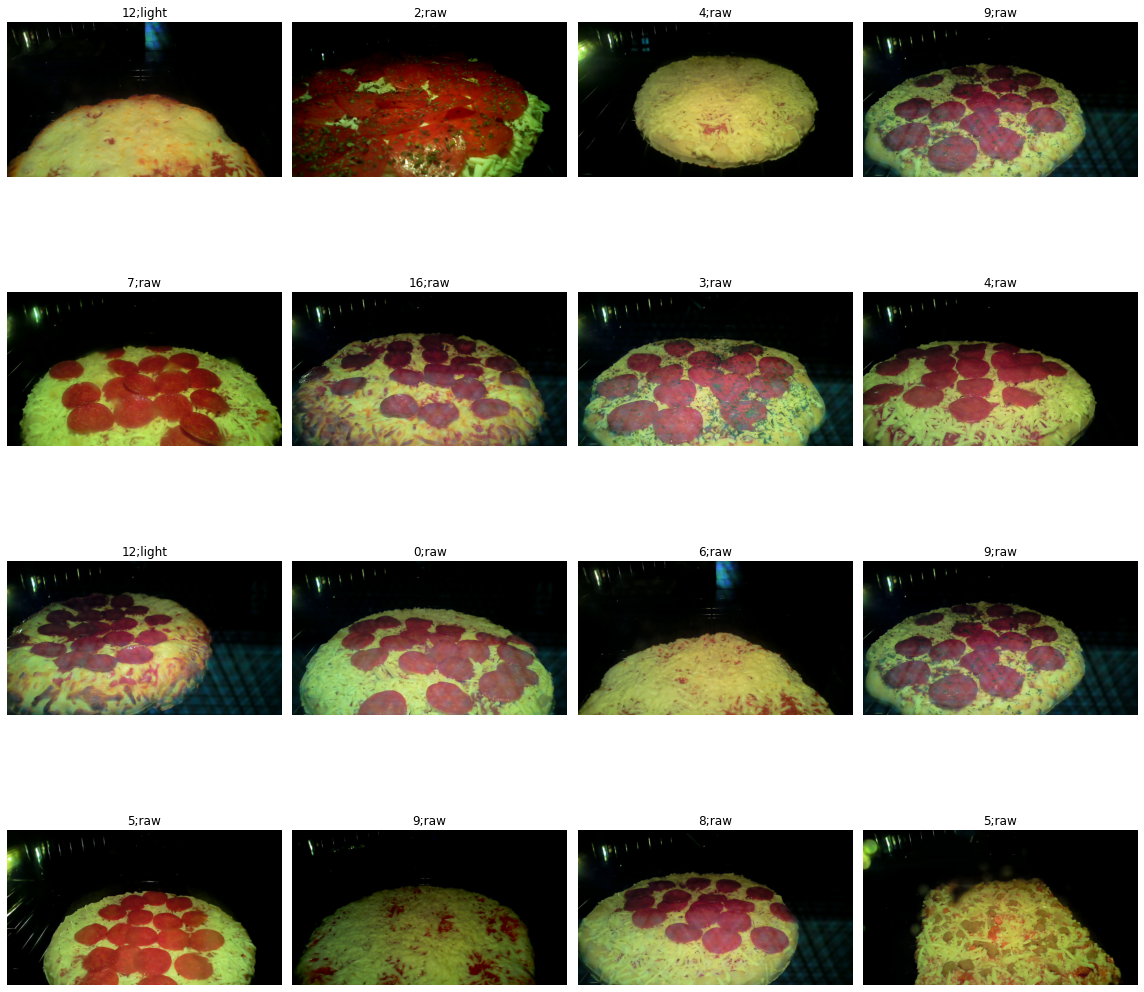

In [ ]:
data.show_batch()

In [ ]:
len(data.train_ds), len(data.valid_ds)

(5489, 1392)

In [ ]:
print(data.classes)
print(len(data.classes),data.c)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', 'dark', 'light', 'medium', 'raw']
24 24


In [ ]:
data.train_ds.y.items[:,0]

array([23, 23, 23, 23, ..., 22, 22, 22, 22])

In [ ]:
#vc = pd.value_counts(data.train_ds.items.pizza_levels_20, sort=False)
vc = pd.value_counts(data.train_ds.y.items[:,1], sort=False)
#vc.index = data.classes
vc

0     243
4     303
8     128
12    445
16    407
1     390
5     267
9      67
13    403
17    305
2     336
6     192
10     35
14    425
18    376
3     295
7     162
11     19
15    352
19    339
dtype: int64

## Create Model Resnet34





In [ ]:
from fastai.metrics import *

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)


In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score])


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


## Stage 1

In [ ]:
learn.fit_one_cycle(5, max_lr=1E-04)


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.994967,0.796215,0.187560,0.304034,14:34
1,0.846865,0.657245,0.215727,0.321139,05:53
2,0.705998,0.539242,0.253861,0.334623,05:54
3,0.632179,0.490003,0.294061,0.344113,05:54
4,0.616194,0.472734,0.304328,0.349511,05:52


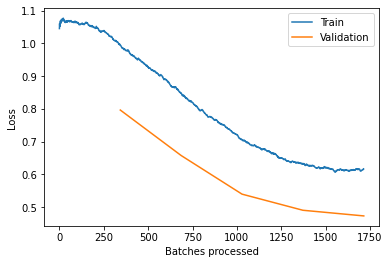

In [ ]:
learn.recorder.plot_losses()

In [ ]:

learn.model_dir='/content/drive/My Drive/FellowAI/Models'
learn.model_dir

'/content/drive/My Drive/FellowAI/Models'

In [ ]:

learn.save("stage-1_SessionSplit_H4_20Levels_Resnet34")

In [ ]:
learn.load('stage-1_SessionSplit_H4_20Levels_Resnet34')
print("Success Loaded")

Success Loaded


In [ ]:
learn.unfreeze()

## Stage 2

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 1.00E-02


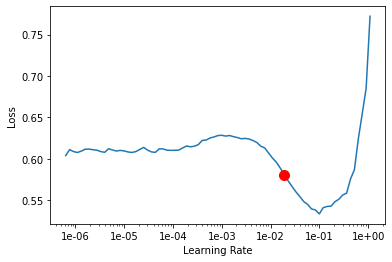

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
#learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))
learn.fit_one_cycle(5, max_lr=slice(1E-03,1E-02))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.221005,1.157603,0.847162,0.164556,08:12
1,0.194167,0.198396,0.902000,0.500195,08:06
2,0.167740,0.194340,0.921007,0.496571,08:06
3,0.147270,0.167499,0.923821,0.535548,08:04
4,0.131358,0.167814,0.920528,0.549114,08:05


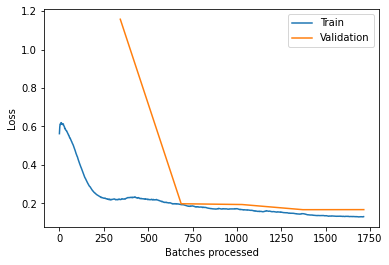

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save("stage-2_SessionSplit_H4_20Levels_Resnet34")

In [ ]:
learn.load('stage-2__SessionSplit_H4_20Levels__Resnet34')
print("Success Loaded")

Success Loaded


## Stage 3

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 4.79E-07


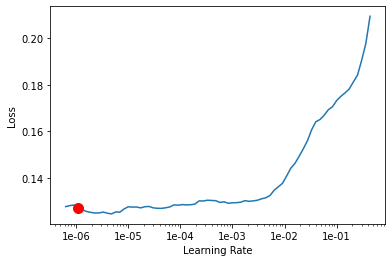

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
#learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))
learn.fit_one_cycle(3, max_lr=slice(1E-06,5E-5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.127854,0.166592,0.920797,0.553139,08:06
1,0.128013,0.167399,0.919600,0.559415,08:05
2,0.129384,0.166753,0.918493,0.553728,08:06


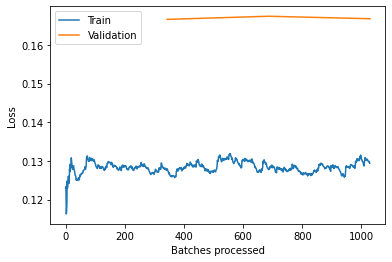

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save("stage-3_SessionSplit_H4_20Levels_Resnet34")

In [ ]:
learn.model_dir='/content/drive/My Drive/FellowAI/Models'
learn.load('stage-3_SessionSplit_H4_20Levels_Resnet34')
print("Success Loaded")

Success Loaded


## Stage 4

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(9.12E-07,1E-05))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save("stage-4_SessionSplit_H4_20Levels_Resnet34")

In [ ]:
learn.load('stage-4_SessionSplit_H4_20Levels_Resnet34')
print("Success Loaded")

## Stage 5

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3, max_lr=6.31E-07)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save("stage-5_SessionSplit10Levels_Resnet34")

In [ ]:
learn.load('stage-5_SessionSplit10Levels_Resnet34')
print("Success Loaded")

Success Loaded


## Stage 6

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(9.12E-07,5E-06))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save("stage-6_SessionSplit_H4_20Levels_Resnet34")

In [ ]:
learn.load('stage-6_SessionSplit_H4_20Levels_Resnet34')
print("Success Loaded")

## Training Results Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()



False

In [ ]:
len(idxs)

33408

In [ ]:
len(data.valid_ds),len(losses),len(idxs)

(1392, 33408, 33408)

185 misclassified samples over 1392 samples in the validation set.


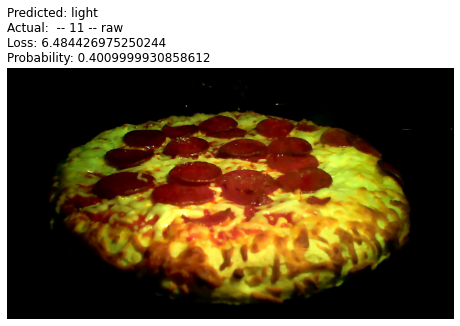

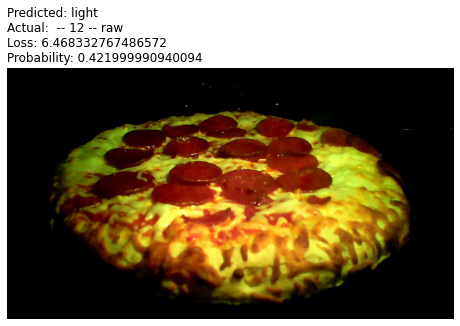

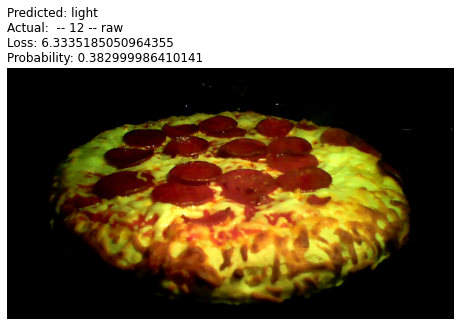

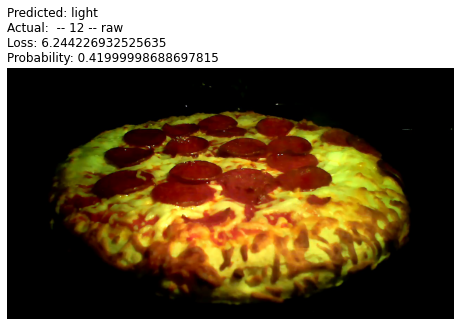

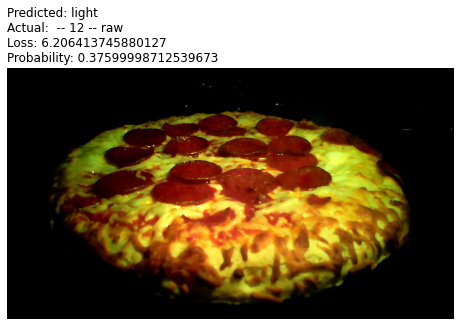

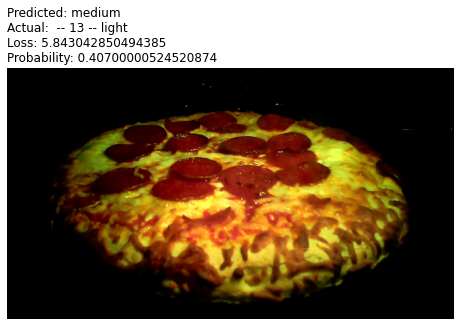

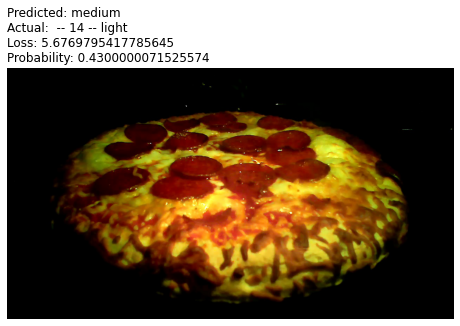

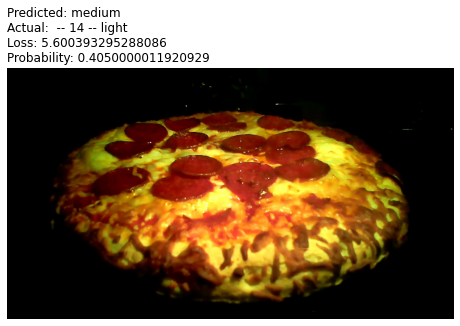

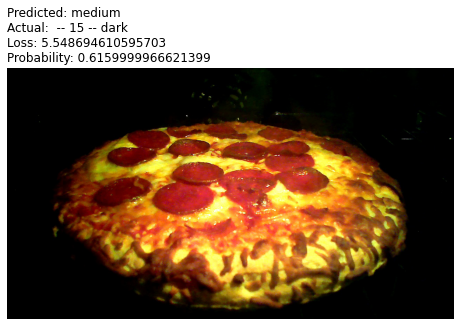

In [ ]:
interp.plot_multi_top_losses(9)

In [ ]:
interp.most_confused()

[('0', 'raw', 25322),
 ('0', 'medium', 3036),
 ('1', 'raw', 2302),
 ('0', 'light', 2266),
 ('1', 'medium', 276),
 ('1', 'light', 206)]

## Save the Model

In [ ]:
learn.model_dir='/content/drive/My Drive/FellowAI/Models'
learn.model_dir

'/content/drive/My Drive/FellowAI/Models'

In [ ]:
# export the model
learn.export('/content/drive/My Drive/FellowAI/Models/Fastai_SessionSplit_H4_20Levels_Resnet34.pkl')
print("Model Saved!")

Model Saved!


## Testing on Session Split Test Set 20 Cooking Levels

In [ ]:
learn.model_dir='/content/drive/My Drive/FellowAI/Models'
learn.load('stage-3_SessionSplit_H4_20Levels_Resnet34')
print("Success Loaded")

Success Loaded


In [ ]:
#defaults.device = torch.device('cpu')

In [ ]:
df=pd.read_csv(path/'pizza_doneness_test_labels/Pizza_test_sessions_v2.csv')
# Create A multi label tag
df_test=df.copy()
df_test['pizza_levels_20']=df['pizza_levels_20'].astype('string')
df_test['tags_4H_20Lv']= df_test[['label', 'pizza_levels_20']].agg(','.join, axis=1)



In [ ]:
# Split test sessions into two groups Test1 andf Test2
unique_Sess=df_test["pizza_session_id"].unique()
print(len(unique_Sess))
import random
random.seed(42)
random.shuffle(unique_Sess)
test1_Sess = unique_Sess[:15]     # consider 64 pizza sessions for Training 
test2_Sess=unique_Sess[15:]     # consider 16 pizza sessions for  Validation
df_test['split']=df_test['pizza_session_id'].apply(lambda x: 'test1' if x in test1_Sess else 'test2')
#df_test1=df_test[(df_test['split']=='test1')]
#df_test2=df_test[(df_test['split']=='test2')]
#print('test1,test2',len(df_test1),len(df_test2))

31
test1,test2 1751 1687


In [ ]:
# Adding Test Set to Databunch
test_set=ImageList.from_df(df_test, path=path/"pizza_doneness_test_labels",cols='image')

data.add_test(test_set)

learn.model.eval()
# get_preds() calculate the accuracy consecutively 
preds,*_ =learn.get_preds(DatasetType.Test)
preds = preds.detach().numpy()


In [ ]:
# save predictions for later use
with open('/content/drive/My Drive/FellowAI/Pizza/preds_31_Sess.pkl', 'wb') as f:
    pickle.dump(preds , f)

In [ ]:
# load predictions for later use
with open('/content/drive/My Drive/FellowAI/Pizza/preds_31_Sess.pkl', 'rb') as f:
    preds = pickle.load(f)

In [ ]:
pred_msk = np.asarray(preds>0.2, dtype=np.int32)


In [ ]:
#Actual
test_set_lbl=test_set.split_none().label_from_df('tags_4H_20Lv',label_delim=',')
print(test_set_lbl.train.y.c2i)
y=[test_set_lbl.train.y[i].data for i in range(len(test_set_lbl.train.y))]


{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, 'dark': 20, 'light': 21, 'medium': 22, 'raw': 23}


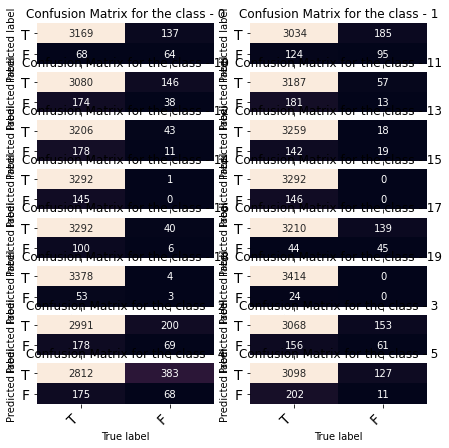

In [ ]:
 cm = multilabel_confusion_matrix(y, pred_msk)
 labels =test_set_lbl.train.y.c2i

 import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

fig, ax = plt.subplots(8, 2, figsize=(7, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["T", "F"])
    
fig.tight_layout()
plt.show() 

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
Pred=[data.classes[20 + preds[i][20:].argmax(0)] for i in range(len(pred_msk))]
Act=[data.classes[20 + y[i][20:].argmax(0)] for i in range(len(y))]
s=0
for i in range(len(Pred)-1):
  if "".join(str(Pred[i]))=="".join(str(Act[i])):
    s+=1
Acc=s/len(Pred)
print("Accuracy=",Acc)
PredLv=[int(data.classes[ preds[i][:20].argmax(0)]) for i in range(len(preds))]
ActLv=[int(data.classes[ y[i][:20].argmax(0)]) for i in range(len(y))]

r2=r2_score(ActLv,PredLv)
print('R-squared=',r2)

MSE=mean_squared_error(PredLv,ActLv)
print('RMSE=', sqrt(MSE))

Accuracy= 0.8109365910413031
R-squared= 0.6490614290181094
RMSE= 2.9478204054054453


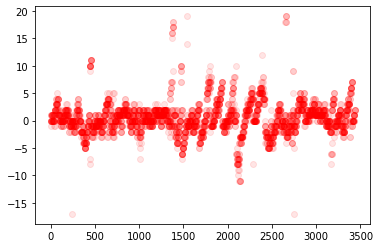

In [ ]:
# Plot of Error Difference
g=plt.plot([x-y for x,y in zip(ActLv,PredLv)] ,color='r',marker='o',linestyle='', alpha=0.1)

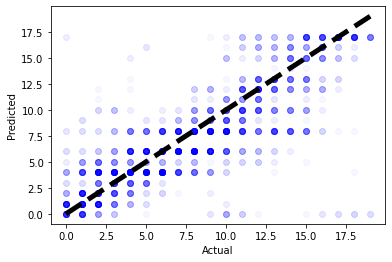

In [ ]:
# Plot of cross validation
from sklearn.model_selection import cross_val_predict

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

fig, ax = plt.subplots()
ax.scatter(ActLv, PredLv,alpha=0.03, color='b')
ax.plot([min(ActLv), max(ActLv)], [min(ActLv), max(ActLv)], 'k--', lw=5)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
# Creat A for prediction table
import ntpath
import pandas as pd
test_predictions = []
for k,(i,fname) in enumerate(zip(preds,data.test_ds.items)):
    test_predictions.append({'file_name':ntpath.basename(fname),
                             'image_path':fname,
                             'Pred_Lbl_Lvl':[data.classes[20 + i[20:].argmax(0)],data.classes[ i[:20].argmax(0)]],
                             'Pred_Lvl':int(data.classes[i[:20].argmax(0)]),
                             'Pred_Lbl':data.classes[20 + i[20:].argmax(0)],
                             'Act_Lvl':int(data.classes[ y[k][:20].argmax(0)]),
                             'Act_Lbl':data.classes[20 + y[k][20:].argmax(0)],
                             'Prob_Lvl':i[:20],
                             'Prob_Lbl':i[20:]
                             })
    print(k,"- predicted=", [data.classes[20 +i[20:].argmax(0)],data.classes[i[:20].argmax(0)]],",\t Actual=",data.classes[20 + y[k][20:].argmax(0)], ",\t FilName=",fname)
    #print(i)

In [ ]:
# save df for later use
with open('/content/drive/My Drive/FellowAI/Pizza/test_predictions_4H_20Lv.pkl', 'wb') as f:
    pickle.dump(test_predictions, f)

## Conventional Maping from 20 to to 4 Labels Using Cutoffs 

In [ ]:

Pred_labels=[]
for i in range(len(PredLv)-1):
  if PredLv[i] >=18:    # dark split
    Pred_labels.append('dark')
  elif PredLv[i]  >=16:   # medium split
    Pred_labels.append('medium')
  elif PredLv[i]  >=13:   # light split 
    Pred_labels.append('light')
  else:
      Pred_labels.append('raw')

len(PredLv),len(Pred_labels)

# Calculating Accuracy
s=0
for i in range(len(Pred_labels)-1):
  if(Pred_labels[i]==Act[i]):
    s+=1
Acc=s/len(Pred_labels)
print("Accuracy=",Acc)


Accuracy= 0.8175734652313064


# 2. Ordinal Logistic Regression Mapping


Ordinal Logistic Regression
Ordinal logistic regression models the relationship between a set of predictors and an ordinal response variable. An ordinal response has at least three groups which have a natural order

In [ ]:
with open('/content/drive/My Drive/FellowAI/Pizza/test_predictions_4H_20Lv.pkl', 'rb') as f:
    test_predictions = pickle.load(f)

## Prepare Dataset

In [ ]:
# Source:https://gist.github.com/analyticsindiamagazine/d15be32d50d65c967412cb69b2dc601b
#https://analyticsindiamag.com/a-hands-on-guide-to-regression-with-fast-ai/

In [ ]:
from fastai.tabular import *

In [ ]:
df=pd.DataFrame.from_dict(test_predictions)

In [ ]:
df.head(1)

,file_name,image_path,Pred_Lbl_Lvl,Pred_Lvl,Pred_Lbl,Act_Lvl,Act_Lbl,Prob_Lvl,Prob_Lbl
0,cdaa4ff8-6586-4a23-993f-8cc71b61008d.jpg,/content/drive/My Drive/FellowAI/Pizza/DS/pizz...,"[raw, 1]",1,raw,0,raw,"[0.3342121, 0.36297318, 0.00010472168, 7.29052...","[0.00013282783, 0.00035414484, 0.00058756734, ..."


In [ ]:
#df['Prob_Lvl']=df['Prob_Lvl'].apply(lambda x: x.numpy().tolist())
#df['Prob_Lbl']=df['Prob_Label'].apply(lambda x: x.numpy().tolist())

In [ ]:
df[['Prb_Lvl_'+s  for s in data.classes[:20]] ] = pd.DataFrame(df['Prob_Lvl'].tolist(), index= df.index)
df[['Prb_Lbl_'+s  for s in data.classes[20:]] ] = pd.DataFrame(df['Prob_Lbl'].tolist(), index= df.index)
#df[['Act_Lbl','Act_Lvl'] ] = pd.DataFrame(df['actual_class'].tolist(), index= df.index)
#df[['Pred_Lbl','Pred_Lvl'] ] = pd.DataFrame(df['labeled_class'].tolist(), index= df.index)

In [ ]:
df['Act_Lbl_num']=df['Act_Lbl'].apply(lambda x: 0 if x=='raw' else (1 if x=='light'else (2 if x=='medium' else 3 if x=='dark' else '')))

In [ ]:
# Split to train test set
msk = np.random.rand(len(df)) < 0.8
train_set =df[msk]
test_set = df[~msk]

In [ ]:
test_set.head(1)

,file_name,image_path,Pred_Lbl_Lvl,Pred_Lvl,Pred_Lbl,Act_Lvl,Act_Lbl,Prob_Lvl,Prob_Lbl,Prb_Lvl_0,Prb_Lvl_1,Prb_Lvl_10,Prb_Lvl_11,Prb_Lvl_12,Prb_Lvl_13,Prb_Lvl_14,Prb_Lvl_15,Prb_Lvl_16,Prb_Lvl_17,Prb_Lvl_18,Prb_Lvl_19,Prb_Lvl_2,Prb_Lvl_3,Prb_Lvl_4,Prb_Lvl_5,Prb_Lvl_6,Prb_Lvl_7,Prb_Lvl_8,Prb_Lvl_9,Prb_Lbl_dark,Prb_Lbl_light,Prb_Lbl_medium,Prb_Lbl_raw,Act_Lbl_num
1,7100c301-6562-4354-b20c-5f3502761ed4.jpg,/content/drive/My Drive/FellowAI/Pizza/DS/pizz...,"[raw, 0]",0,raw,0,raw,"[0.5281121, 0.47238016, 3.9832335e-05, 2.44461...","[0.000112058726, 0.00016822488, 0.0005023324, ...",0.528112,0.47238,0.00004,0.000024,0.000067,0.000048,0.000079,0.000079,0.000095,0.000101,0.000029,0.000142,0.212252,0.044636,0.014,0.002335,0.000368,0.0002,0.00014,0.000168,0.000112,0.000168,0.000502,0.998462,0


## Creating A TabularList

In [ ]:
defaults.device = torch.device('cuda')

In [ ]:
#Path / default location for saving/loading models
path 

#The dependent variable/target
dep_var = 'Act_Lbl_num'

#The list of categorical features in the dataset
cat_names = ''

#The list of continuous features in the dataset
#Exclude the Dependent variable 
l=['Prb_Lvl_'+s  for s in data.classes[:20]]
l.extend(['Prb_Lbl_'+s  for s in data.classes[20:]])

cont_names =l

#List of Processes/transforms to be applied to the dataset
procs = [FillMissing, Categorify, Normalize]


In [ ]:
#Start index for creating a validation set from train_data
start_indx = len(train_set) - int(len(train_set) * 0.2)

#End index for creating a validation set from train_data
end_indx = len(train_set)
#TabularList for Validation
val = (TabularList.from_df(train_set.iloc[start_indx:end_indx].copy(), path='.', cat_names=cat_names, cont_names=cont_names, procs=procs))
test = (TabularList.from_df(test_set, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs))

In [ ]:
#TabularList for training
Reg_data = (TabularList.from_df(train_set, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(start_indx,end_indx)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch(bs=32))
#Display the data batch
Reg_data.show_batch(rows = 5)

Prb_Lvl_0,Prb_Lvl_1,Prb_Lvl_10,Prb_Lvl_11,Prb_Lvl_12,Prb_Lvl_13,Prb_Lvl_14,Prb_Lvl_15,Prb_Lvl_16,Prb_Lvl_17,Prb_Lvl_18,Prb_Lvl_19,Prb_Lvl_2,Prb_Lvl_3,Prb_Lvl_4,Prb_Lvl_5,Prb_Lvl_6,Prb_Lvl_7,Prb_Lvl_8,Prb_Lvl_9,Prb_Lbl_dark,Prb_Lbl_light,Prb_Lbl_medium,Prb_Lbl_raw,target
-0.3416,-0.4453,0.5979,0.4670,0.7104,0.6165,0.5861,0.2613,0.1266,-0.1753,0.0484,-0.2578,-0.6528,-0.6593,-0.6376,-0.5002,-0.3910,0.5286,1.6519,1.3567,-0.2306,0.8338,-0.1844,-0.3852,1
-0.2984,-0.3824,-0.0087,-0.2862,-0.3803,-0.3407,-0.3500,-0.3505,-0.3465,-0.3237,-0.3184,-0.3229,-0.4142,-0.4136,-0.1585,0.2123,1.2339,2.2363,2.1145,1.1862,-0.2993,-0.3913,-0.3882,0.4803,0
-0.3634,-0.4654,-0.5203,-0.5551,-0.5706,-0.5911,-0.5874,-0.5849,-0.5205,-0.3824,-0.4137,-0.3564,-0.5096,-0.0072,0.6179,1.5418,2.3994,1.5916,0.4987,-0.2627,-0.3458,-0.5529,-0.4337,0.5750,0
-0.3659,-0.5326,-0.5452,-0.3926,-0.0530,0.9166,1.6183,3.2704,3.7143,2.4496,2.0376,2.2361,-0.8181,-0.9111,-0.9936,-1.0109,-0.9719,-0.9373,-0.8441,-0.7175,1.9354,1.4334,3.4317,-2.3104,3
1.6646,2.7424,-0.5924,-0.5865,-0.5939,-0.6178,-0.6120,-0.5946,-0.5262,-0.3828,-0.4177,-0.3533,2.7617,0.5733,-0.4887,-0.8776,-0.9409,-0.9336,-0.8697,-0.7845,-0.3462,-0.5592,-0.4339,0.5761,0


## Initializing Neural Network

In [ ]:

f1_score = FBeta(average='weighted', beta=1)

Reg_learn = tabular_learner(Reg_data, layers=[500,400,300,200, 100, 50], metrics= [accuracy,f1_score])
#Show the complete Summary of the model
#learn.summary

## Training The Network

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.24E-02
Min loss divided by 10: 5.25E-02


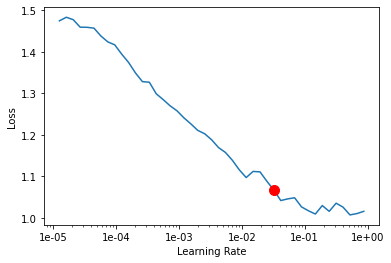

In [ ]:
Reg_learn.lr_find(start_lr = 1e-06,end_lr = 1e+05, num_it = 100)
Reg_learn.recorder.plot(suggestion=True)

In [ ]:
#Fitting data and training the network
Reg_learn.fit_one_cycle(5,max_lr=1E-01)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.585420,1.215035,0.589512,0.655172,00:01
1,0.540955,0.650247,0.802893,0.762787,00:01
2,0.501591,0.345831,0.886076,0.885123,00:01
3,0.456033,0.289097,0.886076,0.876183,00:01
4,0.415160,0.309092,0.884268,0.883291,00:01


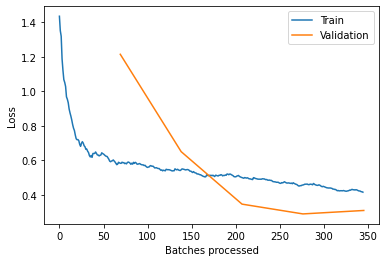

In [ ]:
Reg_learn.recorder.plot_losses()

In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-01)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.441649,0.481817,0.855335,0.840687,00:01
1,0.521670,0.909275,0.846293,0.811295,00:01
2,0.473860,0.494837,0.815552,0.817150,00:01
3,0.420989,0.298772,0.877034,0.871680,00:01
4,0.402030,0.291844,0.893309,0.890441,00:01


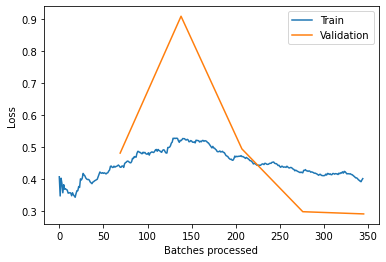

In [ ]:
Reg_learn.recorder.plot_losses()

In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-06)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.382195,0.293180,0.889693,0.887640,00:01
1,0.384510,0.293536,0.891501,0.890537,00:01
2,0.385004,0.284513,0.900542,0.894062,00:01
3,0.388404,99.919388,0.869801,0.871090,00:01
4,0.388933,0.291588,0.891501,0.889235,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-06)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.393237,0.295728,0.887884,0.885425,00:01
1,0.398939,6.623982,0.880651,0.878991,00:01
2,0.402004,11.109357,0.887884,0.888261,00:01
3,0.396159,66.512970,0.880651,0.879475,00:01
4,0.406177,0.292093,0.896926,0.894180,00:01


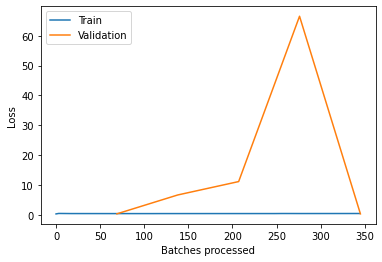

In [ ]:
Reg_learn.recorder.plot_losses()

In [ ]:
Reg_learn.model_dir='/content/drive/My Drive/FellowAI/Models'
Reg_learn.save('Reg_H4_Lv20')

In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-06)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.391339,0.292157,0.891501,0.890537,00:01
1,0.384993,0.286937,0.893309,0.891190,00:01
2,0.382726,1415.712646,0.891501,0.887390,00:01
3,0.378848,0.289995,0.900542,0.894512,00:01
4,0.384507,0.301104,0.891501,0.890537,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-05)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.402650,0.276128,0.884268,0.880524,00:01
1,0.386951,0.297025,0.891501,0.891159,00:01
2,0.384837,0.302122,0.889693,0.889168,00:01
3,0.394175,0.294743,0.884268,0.882180,00:01
4,0.381482,117.761421,0.893309,0.888133,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-05)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.379973,0.289051,0.891501,0.887262,00:01
1,0.380255,0.286701,0.889693,0.886941,00:01
2,0.393220,0.293119,0.889693,0.886941,00:01
3,0.386940,0.290090,0.889693,0.888093,00:01
4,0.394889,0.287175,0.891501,0.886511,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-04)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.404082,0.286500,0.898734,0.895475,00:01
1,0.405696,3.136345,0.887884,0.887685,00:01
2,0.402249,28.405317,0.880651,0.879475,00:01
3,0.389783,0.290232,0.900542,0.897451,00:01
4,0.390748,0.306347,0.878843,0.881975,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-04)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.390711,0.294081,0.898734,0.895822,00:01
1,0.398725,0.281576,0.900542,0.894062,00:01
2,0.398883,0.295251,0.898734,0.893100,00:01
3,0.381974,0.289332,0.904159,0.899961,00:01
4,0.398388,0.295976,0.893309,0.891878,00:01


In [ ]:
Reg_learn.model_dir='/content/drive/My Drive/FellowAI/Models'
Reg_learn.save('Stage2_Reg_H4_Lv20')

In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-03)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.380193,125.875000,0.878843,0.877798,00:01
1,0.386333,0.287964,0.893309,0.888408,00:01
2,0.387064,0.287824,0.902351,0.898602,00:01
3,0.395707,96.770103,0.880651,0.882327,00:01
4,0.395714,2.500177,0.887884,0.886272,00:01


In [ ]:
Reg_learn.model_dir='/content/drive/My Drive/FellowAI/Models'
Reg_learn.save('Stage3_Reg_H4_Lv20')

In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-03)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.382378,0.286270,0.891501,0.887282,00:01
1,0.382120,0.298193,0.893309,0.893084,00:01
2,0.395786,0.283837,0.896926,0.891066,00:01
3,0.381829,53.853260,0.891501,0.891423,00:01
4,0.378256,0.309920,0.891501,0.890920,00:01


In [ ]:
Reg_learn.model_dir='/content/drive/My Drive/FellowAI/Models'
Reg_learn.save('Stage4_Reg_H4_Lv20')

In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-03)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.381946,0.297158,0.900542,0.895566,00:01
1,0.373429,6.437281,0.882459,0.880874,00:01
2,0.384812,92.073807,0.887884,0.890928,00:01
3,0.392595,288.509216,0.889693,0.889672,00:01
4,0.376248,0.299204,0.907776,0.903559,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-03)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.374454,0.299569,0.902351,0.899760,00:01
1,0.377317,0.301448,0.900542,0.897800,00:01
2,0.381026,0.294486,0.904159,0.899639,00:01
3,0.383282,0.302800,0.900542,0.895566,00:01
4,0.374505,0.294851,0.907776,0.902789,00:01


In [ ]:
Reg_learn.model_dir='/content/drive/My Drive/FellowAI/Models'
Reg_learn.save('Stage4_Reg_H4_Lv20')

In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-03)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.368983,0.291873,0.896926,0.895550,00:01
1,0.371947,467.388824,0.886076,0.883856,00:01
2,0.371809,0.310082,0.891501,0.889593,00:01
3,0.369052,46.048565,0.900542,0.897333,00:01
4,0.359630,245.403656,0.902351,0.898811,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=5E-03)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.365930,0.319465,0.902351,0.899964,00:01
1,0.372866,0.284797,0.902351,0.897314,00:01
2,0.380669,420.507996,0.884268,0.884849,00:01
3,0.364510,0.312476,0.891501,0.889764,00:01
4,0.355885,0.296931,0.905967,0.901110,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=1E-03)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.358827,3575.888916,0.891501,0.892715,00:01
1,0.353445,0.296851,0.900542,0.896752,00:01
2,0.356483,0.327208,0.884268,0.883307,00:01
3,0.356598,0.303886,0.904159,0.898699,00:01
4,0.357365,0.308103,0.893309,0.888603,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=2E-03)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.345055,0.339910,0.848101,0.847196,00:01
1,0.349433,815.853088,0.875226,0.875232,00:01
2,0.363881,0.307863,0.869801,0.872706,00:01
3,0.355352,0.308698,0.886076,0.884882,00:01
4,0.338823,0.320845,0.867993,0.868036,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=2E-04)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.340804,0.329445,0.853526,0.856527,00:01
1,0.353166,35636.664062,0.853526,0.857941,00:01
2,0.360661,0.342947,0.831826,0.840799,00:01
3,0.336125,1455.369751,0.877034,0.876010,00:01
4,0.329488,0.309953,0.860759,0.863131,00:01


In [ ]:
Reg_learn.fit_one_cycle(5,max_lr=2E-04)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.348687,0.315826,0.880651,0.878964,00:01
1,0.346241,0.302027,0.895118,0.890117,00:01
2,0.336685,0.319460,0.873418,0.873288,00:01
3,0.343745,0.348169,0.857143,0.859593,00:01
4,0.339052,0.315785,0.880651,0.878964,00:01


In [ ]:
Reg_learn.model_dir='/content/drive/My Drive/FellowAI/Models'
Reg_learn.save('Stage5_Reg_H4_Lv20')

## Ordinal Regression Learning Results

In [ ]:
#Display Predictions On Training Data
Reg_learn.show_results(ds_type=DatasetType.Train,rows = 5)

Prb_Lvl_0,Prb_Lvl_1,Prb_Lvl_10,Prb_Lvl_11,Prb_Lvl_12,Prb_Lvl_13,Prb_Lvl_14,Prb_Lvl_15,Prb_Lvl_16,Prb_Lvl_17,Prb_Lvl_18,Prb_Lvl_19,Prb_Lvl_2,Prb_Lvl_3,Prb_Lvl_4,Prb_Lvl_5,Prb_Lvl_6,Prb_Lvl_7,Prb_Lvl_8,Prb_Lvl_9,Prb_Lbl_dark,Prb_Lbl_light,Prb_Lbl_medium,Prb_Lbl_raw,target,prediction
-0.3880,-0.5518,0.6034,1.6160,3.2839,2.8401,2.3331,0.6961,0.1053,-0.3050,-0.2678,-0.3125,-0.8249,-0.9078,-0.9831,-0.9990,-0.9465,-0.8329,-0.6245,-0.2749,-0.3246,2.3512,-0.2779,-0.7240,1,0
-0.2801,-0.1885,-0.5702,-0.5735,-0.5823,-0.5979,-0.5910,-0.5815,-0.5141,-0.3801,-0.4089,-0.3538,0.1865,0.4915,0.6626,0.9542,0.9692,0.3427,-0.2648,-0.6094,-0.3434,-0.5477,-0.4304,0.5708,0,0
-0.3785,-0.5259,-0.0642,-0.3896,-0.4978,-0.5370,-0.5483,-0.5638,-0.5135,-0.3813,-0.4116,-0.3561,-0.7296,-0.6395,-0.3784,0.0866,1.9193,2.8147,2.1197,1.4568,-0.3454,-0.5481,-0.4332,0.5741,0,0
1.8230,2.0159,-0.5921,-0.5868,-0.5926,-0.6167,-0.6111,-0.5930,-0.5230,-0.3818,-0.4174,-0.3470,0.9857,-0.3783,-0.8292,-0.9553,-0.9538,-0.9335,-0.8681,-0.7786,-0.3455,-0.5598,-0.4307,0.5704,0,0
0.4209,0.8876,-0.5831,-0.5771,-0.5673,-0.6008,-0.5757,-0.5751,-0.5009,-0.3753,-0.4055,-0.3317,0.9820,0.5657,-0.2829,-0.5634,-0.7174,-0.7907,-0.8211,-0.7332,-0.3418,-0.5478,-0.4236,0.5628,0,0


In [ ]:
#Display Predictions On Validation Data
Reg_learn.show_results(ds_type=DatasetType.Valid)

Prb_Lvl_0,Prb_Lvl_1,Prb_Lvl_10,Prb_Lvl_11,Prb_Lvl_12,Prb_Lvl_13,Prb_Lvl_14,Prb_Lvl_15,Prb_Lvl_16,Prb_Lvl_17,Prb_Lvl_18,Prb_Lvl_19,Prb_Lvl_2,Prb_Lvl_3,Prb_Lvl_4,Prb_Lvl_5,Prb_Lvl_6,Prb_Lvl_7,Prb_Lvl_8,Prb_Lvl_9,Prb_Lbl_dark,Prb_Lbl_light,Prb_Lbl_medium,Prb_Lbl_raw,target,prediction
-0.3047,-0.3168,-0.4339,-0.5281,-0.5366,-0.5630,-0.5648,-0.5624,-0.5031,-0.3795,-0.4071,-0.3514,-0.1128,0.1345,0.5765,0.5574,1.5612,1.5681,0.3703,-0.1955,-0.3439,-0.5343,-0.4295,0.5686,0,0
0.5151,1.8755,-0.5930,-0.5867,-0.5939,-0.6178,-0.6116,-0.5952,-0.5268,-0.3831,-0.4179,-0.3540,2.8876,1.3337,-0.2237,-0.7314,-0.8781,-0.9154,-0.8694,-0.7836,-0.3466,-0.5604,-0.4343,0.5770,0,0
0.4027,1.5010,-0.5920,-0.5853,-0.5906,-0.6157,-0.6072,-0.5924,-0.5240,-0.3822,-0.4162,-0.3512,2.2987,1.0735,-0.2204,-0.6631,-0.8351,-0.8863,-0.8626,-0.7765,-0.3460,-0.5589,-0.4331,0.5758,0,0
0.4391,1.6778,-0.5928,-0.5865,-0.5934,-0.6175,-0.6114,-0.5948,-0.5264,-0.3830,-0.4176,-0.3540,2.7069,1.0858,-0.2636,-0.7271,-0.8702,-0.9060,-0.8670,-0.7815,-0.3465,-0.5602,-0.4341,0.5768,0,0
0.3513,1.3791,-0.5914,-0.5847,-0.5891,-0.6148,-0.6060,-0.5916,-0.5234,-0.3821,-0.4160,-0.3516,2.1077,1.1198,-0.1138,-0.6146,-0.8105,-0.8746,-0.8592,-0.7743,-0.3460,-0.5582,-0.4332,0.5759,0,0


In [ ]:
#Getting The Training And Validation Errors

tr = Reg_learn.validate(Reg_learn.data.train_dl)
va = Reg_learn.validate(Reg_learn.data.valid_dl)
ts = Reg_learn.validate(Reg_learn.data.test_dl)
print("The Metrics used In Evaluating The Network:", str(Reg_learn.metrics))

print("\nThe calculated RMSE & R-Squared For The Training Set :", tr[1:])
print("\nThe calculated RMSE & R-Squared For The Validation Set :", va[1:])

The Metrics used In Evaluating The Network: [<function accuracy at 0x7f2fdccca2f0>, FBeta(average=None, pos_label=1, eps=1e-09, beta=1)]

The calculated RMSE & R-Squared For The Training Set : [tensor(0.8555), tensor(0.8432)]

The calculated RMSE & R-Squared For The Validation Set : [tensor(0.8807), tensor(0.9678), tensor(0.6974), tensor(0.5833), tensor(0.)]


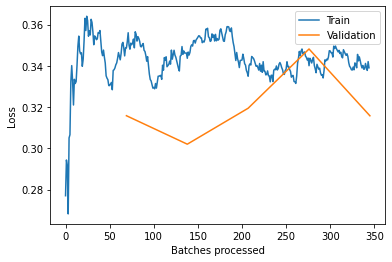

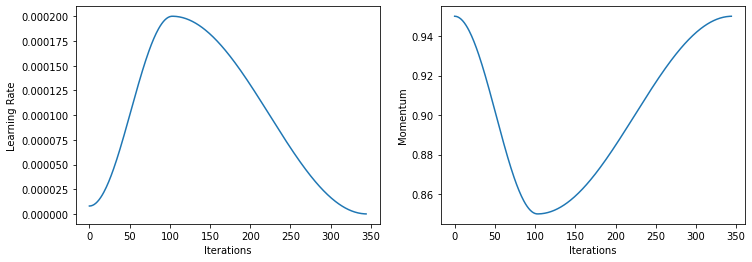

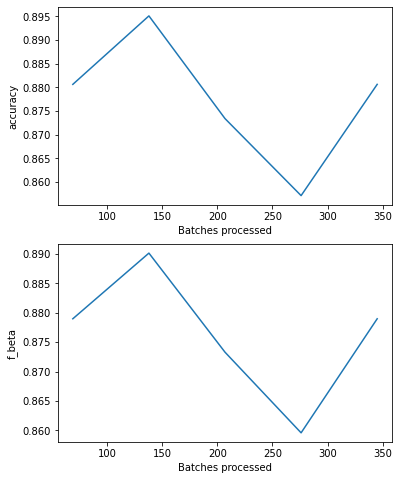

In [ ]:
#Plotting The losses for training and validation
Reg_learn.recorder.plot_losses()
#Plotting Momentum & Learning Rate
Reg_learn.recorder.plot_lr(show_moms=True)
#Plotting the metrics of evaluation
Reg_learn.recorder.plot_metrics()

## Validation Results

In [ ]:
val = train_set.tail(len(Reg_data.valid_ds))
labels=[0,1,2,3]
#Converting the prediction to DataFrame for Comparing
(val_preds, val_Act) = Reg_learn.get_preds(ds_type=DatasetType.Valid)
val_preds = [labels[i.argmax(0)] for i in val_preds] 
val['Reg_Lbl'] = val_preds
val.head(1)

,file_name,image_path,Pred_Lbl_Lvl,Pred_Lvl,Pred_Lbl,Act_Lvl,Act_Lbl,Prob_Lvl,Prob_Lbl,Prb_Lvl_0,Prb_Lvl_1,Prb_Lvl_10,Prb_Lvl_11,Prb_Lvl_12,Prb_Lvl_13,Prb_Lvl_14,Prb_Lvl_15,Prb_Lvl_16,Prb_Lvl_17,Prb_Lvl_18,Prb_Lvl_19,Prb_Lvl_2,Prb_Lvl_3,Prb_Lvl_4,Prb_Lvl_5,Prb_Lvl_6,Prb_Lvl_7,Prb_Lvl_8,Prb_Lvl_9,Prb_Lbl_dark,Prb_Lbl_light,Prb_Lbl_medium,Prb_Lbl_raw,Act_Lbl_num,Reg_Lbl
2746,07d25c8a-6c41-471d-8f4a-5bd57d5472aa.jpg,/content/drive/My Drive/FellowAI/Pizza/DS/pizz...,"[raw, 6]",6,raw,1,raw,"[0.010456818, 0.026478788, 0.010664951, 0.0033...","[0.00029800646, 0.0036723767, 0.00112727, 0.99...",0.010457,0.026479,0.010665,0.003314,0.003211,0.002697,0.001953,0.00147,0.001194,0.000347,0.000262,0.000136,0.053529,0.071018,0.126274,0.110495,0.199968,0.141968,0.101282,0.04036,0.000298,0.003672,0.001127,0.996738,0,0


In [ ]:
Y_true = val[dep_var]
pred = val['Reg_Lbl']

#RMSLE
error = np.square(np.log10(pred + 1) - np.log10(Y_true +1)).mean() ** 0.5

score = 1 - error
print("SCORE For Validation : ",score)
ACC=sum(map(int,val['Reg_Lbl']==val[dep_var]))/len(val[dep_var])
print('Validation Set Accuracy=',ACC)

SCORE For Validation :  0.9205735789117996
Validation Set Accuracy= 0.8806509945750453


# 3. Testing Ordinal Regression using 20 cooking Levels as Features to Classify 4 Human-Based Labels

In [ ]:
Reg_learn.model_dir='/content/drive/My Drive/FellowAI/Models'
#Reg_learn.load('Stage5_Reg_H4_Lv20')

In [ ]:

Reg_learn.model.eval()
#Converting the prediction to DataFrame for Comparing
(tst_preds, tst_Act) = Reg_learn.get_preds(ds_type=DatasetType.Test)
tst_preds = [labels[i.argmax(0)] for i in tst_preds] 
test_set['Reg_test_Lbl'] = tst_preds

Y_true = test_set[dep_var]
pred = test_set['Reg_test_Lbl']

#RMSLE
error = np.square(np.log10(pred + 1) - np.log10(Y_true +1)).mean() ** 0.5

score = 1 - error
print("RMSLE SCORE For Test : ",score)
ACC=sum(map(int,test_set['Reg_test_Lbl']==test_set[dep_var]))/len(test_set[dep_var])
print('Test Set Accuracy=',ACC)

RMSLE SCORE For Test :  0.9149848281522456
Test Set Accuracy= 0.8841010401188707


In [ ]:
#defaults.device = torch.device('cpu')